Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'1.14.0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
# assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Train basic model on the generated emnist-lines dataset

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
# To be able to write code as if this notebook was one level up in files tree structure.
sys.path.append('..')

from pathlib import Path

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

import pandas as pd
from PIL import Image

In [4]:
from recognizer.datasets import Dataset
from recognizer.datasets import EmnistDataset
from recognizer.networks import lenet
from recognizer.networks import simple
from recognizer.networks import NetworkInput

In [5]:
model_save_path = Path("../recognizer/weights/lines_time_distributed_model.h5")

Hyperparameters

In [6]:
batch_size = 16
epochs = 8

## Load characters mapping

In [7]:
import json

with open(Dataset.raw_data_path()/"emnist"/"emnist_essentials.json") as json_file:  
    mapping = json.load(json_file)["mapping"]
    mapping = {m[0]: m[1] for m in mapping}
    mapping[62] = ' '
    mapping[63] = '_'
    
mapping_reversed = {v: k for k, v in mapping.items()}

## Build the new model

In [8]:
char_image_height = 28
char_image_width = 28
max_length = 34
num_classes = 64
image_height = char_image_height
image_width = char_image_width * max_length

input_shape = (image_height, image_width)
output_shape = (max_length, num_classes)

window_width: float = 16
window_stride: float = 8
    
num_windows = ((image_width - window_width) // window_stride) + 1
if num_windows < max_length:
    raise ValueError(f'Window width/stride need to generate >= {max_length} windows (currently {num_windows})')

In [9]:
tensorflow.keras.image.extract_image_patches??

Object `tensorflow.keras.image.extract_image_patches` not found.


In [10]:
def slide_window(image, window_width, window_stride):
    """
    Takes (image_height, image_width, 1) input,
    Returns (num_windows, image_height, window_width, 1) output, where
    num_windows is floor((image_width - window_width) / window_stride) + 1
    """
    patches = tf.image.extract_patches(image, 
                                       sizes=[1, 1, window_width, 1], 
                                       strides=[1, 1, window_stride, 1], 
                                       rates=[1, 1, 1, 1], 
                                       padding='VALID')
    patches = tf.transpose(patches, (0, 2, 1, 3))  # Swap width and height
    patches = tf.expand_dims(patches, -1)
    
    return patches

In [11]:
window_width = 28
# For simplicity sake, let us just make number of windows = number of max characters in a sentence
window_stride = 28. # 14

image_input = layers.Input(shape=input_shape, name='image')
image_reshaped = layers.Reshape((image_height, image_width, 1))(image_input)

image_patches = layers.Lambda(
    slide_window,
    arguments={'window_width': window_width, 'window_stride': window_stride}
)(image_reshaped)

In [12]:
image_patches

<tf.Tensor 'lambda/Identity:0' shape=(?, 34, 28, 28, 1) dtype=float32>

### The model

In [13]:
convnet_base = lenet(NetworkInput(input_shape=(image_height, window_width, 1), number_of_classes=num_classes))
convnet_base.layers

In [14]:
# Get rid of the last two layers (dropout and softmax)
convnet = KerasModel(inputs=convnet_base.inputs, outputs=convnet_base.layers[-2].output)

time_distributed_outputs = layers.TimeDistributed(convnet)(image_patches)

# TODO :: Add conv2D layer to sum the windows.
# time_distributed_outputs = layers.Reshape((67, 128, 1))(time_distributed_outputs)
# time_distributed_outputs = layers.Conv2D(max_length, kernel_size=(width, 128), strides=(width, 1), activation='relu', name='sum_windows')(time_distributed_outputs)

softmax_output = layers.Dense(num_classes, activation='softmax', name='softmax_output')(time_distributed_outputs)

model = KerasModel(
        inputs=image_input,
        outputs=softmax_output
    )

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 952)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 952, 1)        0         
_________________________________________________________________
lambda (Lambda)              (None, 34, 28, 28, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 128)           1198592   
_________________________________________________________________
softmax_output (Dense)       (None, 34, 64)            8256      
Total params: 1,206,848
Trainable params: 1,206,848
Non-trainable params: 0
_________________________________________________________________


## Look at the data

Load emnist lines and pass it to the model

In [15]:
df = pd.read_csv(Dataset.processed_data_path()/"emnist_lines"/"data.csv")

output_length = len(df)

In [16]:
df.head()

,image,sentence
0,0.png,Whats wrong at state _____________
1,1.png,The transducer itself moves the __
2,2.png,There is an ancient and venerable
3,3.png,They destroyed a trading house ___
4,4.png,Alec waited a moment on guard ___


In [17]:
image = Image.open(Dataset.processed_data_path()/"emnist_lines"/"0.png")
image

In [18]:
np.array(image).shape

(28, 952)

## Try it before training

In [19]:
image_numpy = np.array(image).astype(np.float32)
test_batch = image_numpy.reshape(1, image_height, image_width, 1)

preds = model(test_batch)
preds.shape

TensorShape([Dimension(1), Dimension(34), Dimension(64)])

In [20]:
image

In [21]:
for char_pred in preds[0]:
    print(mapping[np.argmax(char_pred)], end='')

OenvT0OwTTT0TT0neeTO00000000000000

## Build the generators

Shuffle the data and reset their index

In [22]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,sentence
0,4578.png,And you think you have language __
1,3059.png,he ran wild with the child gangs _
2,1330.png,We should not allow the image of _
3,7955.png,You saw them always together _____
4,8044.png,The planning division will take __


In [23]:
valid_length = int(len(df) * .2)
valid_df = df.iloc[:valid_length]
train_df = df.iloc[valid_length:]

In [24]:
valid_df.tail()

,image,sentence
1995,1468.png,Parker certainly had much more of
1996,8954.png,Since the writer had not noticed _
1997,4202.png,It was equally clear that as of __
1998,3545.png,During a round of target practice
1999,5407.png,Nonspecific staining could be ____


In [25]:
train_df.head()

,image,sentence
2000,3206.png,In this case it is primarily a ___
2001,6766.png,It struck the 9th green on the ___
2002,7615.png,It is generally an inaccurate ____
2003,4426.png,he tells stories of the Thousand _
2004,6771.png,Social control __________________


In [26]:
class LinesDataSequence(Sequence):
    
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return len(self.df) // batch_size

    def __getitem__(self, idx):
        """Return a single batch."""
        begin = idx * self.batch_size
        end = min(len(df) - 1, (idx + 1) * self.batch_size)

        batch_x = []
        batch_y = []
        for index in range(begin, end):
            row = self.df.iloc[index]
            
            image = Image.open(Dataset.processed_data_path()/'emnist_lines'/row['image'])
            x = np.array(image).astype(np.float32).reshape(image_height, image_width)
            batch_x.append(x)

            y = [mapping_reversed[char] for char in row['sentence']]
            y = to_categorical(y, num_classes).astype(np.int)
            batch_y.append(y)

        return np.array(batch_x), np.array(batch_y)

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 952)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 952, 1)        0         
_________________________________________________________________
lambda (Lambda)              (None, 34, 28, 28, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 128)           1198592   
_________________________________________________________________
softmax_output (Dense)       (None, 34, 64)            8256      
Total params: 1,206,848
Trainable params: 1,206,848
Non-trainable params: 0
_________________________________________________________________


## Train

Check progress in TensorBoard by running `tensorboard --logdir=logs/lines_time_distributed` in terminal

In [28]:
!rm -r ../logs/lines_time_distributed

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_time_distributed')
]

In [29]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit_generator(
    LinesDataSequence(train_df, batch_size),
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=LinesDataSequence(valid_df, batch_size),
    validation_steps=len(valid_df) // batch_size,
    epochs=epochs,
    callbacks=callbacks)
history.history.keys()

W0826 04:15:35.952363 140358255253248 deprecation.py:323] From /home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/32
  1/500 [..............................] - ETA: 16:01 - loss: 10.8647 - acc: 0.0239

W0826 04:15:37.819498 140358255253248 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.205099). Check your callbacks.


500/500 [==============================] - 20s 41ms/step - loss: 1.8171 - acc: 0.6934 - val_loss: 0.4348 - val_acc: 0.8022
Epoch 2/32
500/500 [==============================] - 18s 37ms/step - loss: 0.4421 - acc: 0.8002 - val_loss: 0.3977 - val_acc: 0.8116
Epoch 3/32
500/500 [==============================] - 18s 37ms/step - loss: 0.4037 - acc: 0.8090 - val_loss: 0.3927 - val_acc: 0.7836
Epoch 4/32
117/500 [======>.......................] - ETA: 11s - loss: 0.3897 - acc: 0.8050

KeyboardInterrupt: 

NameError: name 'history' is not defined

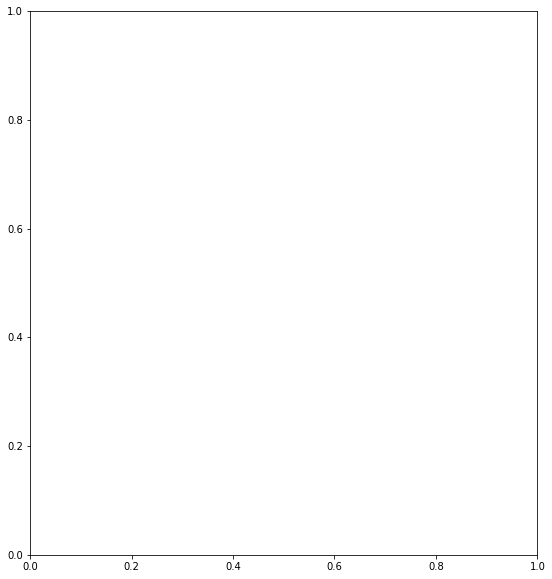

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [32]:
model_save_path

PosixPath('../recognizer/weights/lines_time_distributed_model.h5')

In [33]:
model.save(model_save_path)

## Restore the model

In [34]:
# model = keras.models.load_model(model_save_path)

## Predict

In [35]:
model.trainable = False

# Compile the model for trainable changes to take effect.
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
preds = model(test_batch)
preds.shape

TensorShape([Dimension(1), Dimension(34), Dimension(64)])

In [37]:
image

In [38]:
for char_pred in preds[0]:
    print(mapping[np.argmax(char_pred)], end='')

whats_wrong_at_state______________